# Movie 5

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
import seaborn as sns

movie5_path = "movies/movie5.avi"

In [5]:
# Find contours and get the largest contour to represent the entire structure
# Get bounding rectangle of leftmost and rightmost sides
def get_bounding_boxes(img):
    contours, hierarchy = cv2.findContours(img, 1, 2)
    c = max(contours, key=cv2.contourArea)
    
    leftBoundingRect = cv2.boundingRect(c[c[:, :, 0].argmin()])
    rightBoundingRect = cv2.boundingRect(c[c[:, :, 0].argmax()])

    return leftBoundingRect, rightBoundingRect, c

def check_sections(frame, check_size=10, min_mean_pixel=0.03):
    sections = []
    for c in range(0, frame.shape[1], check_size):
        mean_pixel = cv2.mean(frame[:,c:c+check_size])[0]
        #print("Current mean pixel:", mean_pixel)
        sections.append((mean_pixel, c, check_size))
    return sections

def get_left_side(frame, check_size=10, min_mean_pixel=0.03):
    for c in range(0, frame.shape[1], check_size):
        mean_pixel = cv2.mean(frame[:,c:c+check_size])[0]
        if mean_pixel > min_mean_pixel:
            return c
    return 0

def get_right_side(frame, check_size=10, min_mean_pixel=0.03):
    for c in range(frame.shape[1], 0, -(check_size)):
        mean_pixel = cv2.mean(frame[:,c-check_size:c])[0]
        if mean_pixel > min_mean_pixel:
            return c
    return 0


def get_segment_gaps(right_segments, edge=0, side='left', fill_size=2, space_from_edge=0):
    gaps = []
    for i in range(1,len(right_segments)):
        px, py, pw, ph = right_segments[i-1]
        nx, ny, nw, nh = right_segments[i]
        
        gx = edge+space_from_edge if side=='left' else edge-fill_size-space_from_edge
        gy = (py+ph)-1 if py+ph<=ny else (ny+nh)-1
        gw = fill_size
        gh = ny-(py+ph)+2 if py+ph<=ny else py-(ny+nh) +2

        print("Gap:", (gx, gy, gw, gh))
        gaps.append((gx, gy, gw, gh))
    return gaps

def get_mean_intensity(section):
    count = np.nonzero(section)[0].size
    mean = np.sum(section) / count
    #print(count, mean)
    return count, mean

outliers = []

In [94]:
print("Press 'q' to end video")

cap = cv2.VideoCapture(movie5_path)

# Get movie frame size
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) + 0.5)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) + 0.5)
frame_size = (width, height)

# Initialize video writer to save segmented movie at 1 frame per second
writer = cv2.VideoWriter("movie5_segments.avi", cv2.VideoWriter_fourcc(*"XVID"), 1.0, frame_size)

frame_index = 0

data = []

while True:
    frame_index += 1
    success, frame = cap.read()

    if success and frame.size != 0:
        # Crop frame to remove text
        canvas = np.ones((frame.shape), np.uint8)
        canvas[38:95,:] = frame[38:95,:]
        isolated_cell = frame[38:95,:]
        canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
        
        # Blur to fill threshold gaps
        gray_frame = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)
        _, imgThreshold = cv2.threshold(gray_frame, 15, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        _, imgThresh = cv2.threshold(gray_frame, 10, 255, cv2.THRESH_BINARY)
        blur_frame = cv2.GaussianBlur(imgThresh, (7, 7), 0)

        left_end = get_left_side(blur_frame, check_size=5, min_mean_pixel=17)
        right_end = get_right_side(blur_frame, check_size=5, min_mean_pixel=17)
        #cv2.rectangle(canvas, (left_end, 38), (right_end, 95), (0, 0, 255), 1)

        cell_width = right_end-left_end
        cell_position = left_end
        edge_width = 50


        writer.write(canvas)
        cv2.imshow("Movie 5", imgThreshold)

    # 1 frame per second
    if cv2.waitKey(500) & 0xFF == ord('q'):
        break

cap.release()
writer.release()
cv2.destroyAllWindows()

Press 'q' to end video


## Clean data
- Convert data list to dataframe
- Convert edges to 0 and 1 values (0 for right edge and 1 for left edge)

In [94]:
data_df = pd.DataFrame(data, columns =  ["Frame", "Edge", "Intensity Count","Mean Intensity"])
dummies = pd.get_dummies(data_df)
data_with_dummies_df = pd.concat([data_df, dummies[["Edge_L"]]], axis='columns')
cleaned_data = data_with_dummies_df.drop(['Edge'], axis='columns')*1
cleaned_data.head()

,Frame,Intensity Count,Mean Intensity,Edge_L
0,1,1526,25.859764,0
1,1,1774,56.422210,1
2,2,1727,23.952519,0
3,2,1550,68.036774,1
4,3,1278,24.110329,0


## Exploratory Analysis

<Axes: >

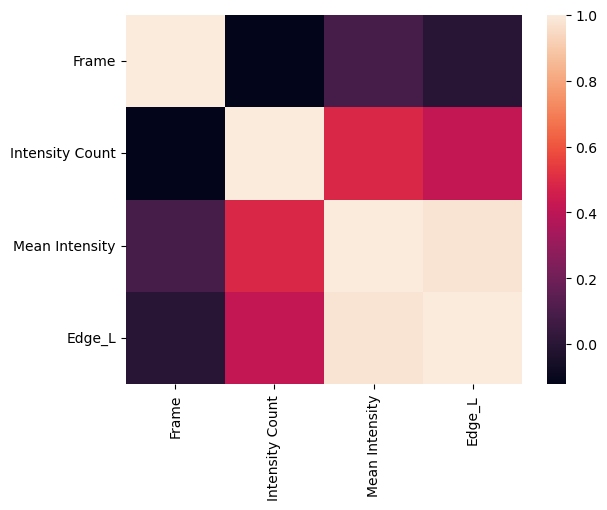

In [97]:
# Correlation
sns.heatmap(cleaned_data.corr())

- Edge_L also correlates strongly with Mean Intensity (Mean fluorescent intensity)

Text(0.5, 0.98, 'Plot Fluorescence at Left (L) and Right (R) edges')

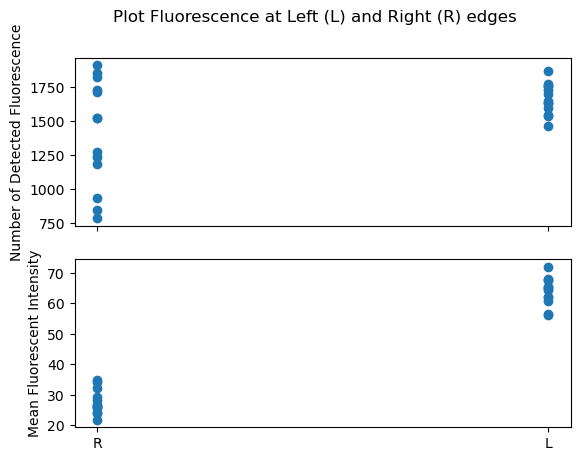

In [100]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
x = data_df["Edge"]
y1 = cleaned_data["Intensity Count"]
y2 = cleaned_data["Mean Intensity"]

ax1.scatter(x, y1)
ax2.scatter(x, y2)
 
ax1.set_ylabel('Number of Detected Fluorescence')
ax2.set_ylabel('Mean Fluorescent Intensity')
 
fig.suptitle('Plot Fluorescence at Left (L) and Right (R) edges')

<Axes: xlabel='Edge', ylabel='Mean Intensity'>

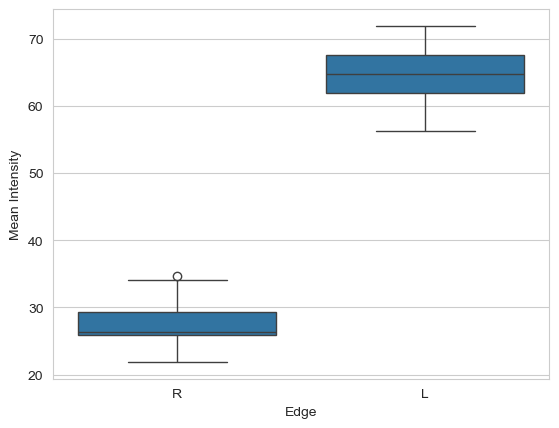

In [102]:
sns.set_style("whitegrid") 
sns.boxplot(x = 'Edge', y = 'Mean Intensity', data = data_df)

- 1 outlier on right edge

<Axes: xlabel='Edge', ylabel='Intensity Count'>

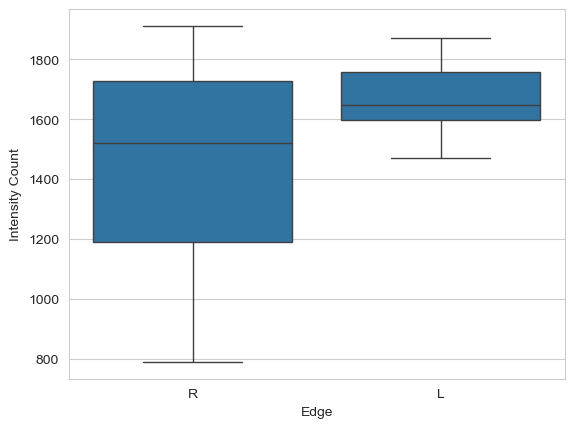

In [105]:
sns.boxplot(x = 'Edge', y = 'Intensity Count', data = data_df)

- Greater variance on the right edge
- There is a lot of fluorescence gathering at the right edge in the movie

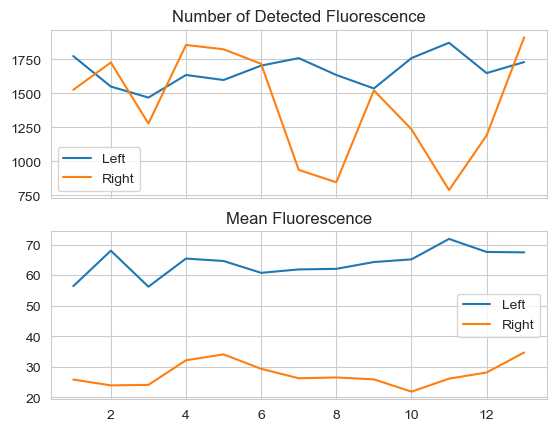

In [108]:
# Compare counts and intensities
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

left_edge_data = data_df[data_df["Edge"] == "L"]
right_edge_data = data_df[data_df["Edge"] == "R"]

X = left_edge_data["Frame"]
Y1 = left_edge_data["Intensity Count"]
Y2 = right_edge_data["Intensity Count"]

Y3 = left_edge_data["Mean Intensity"]
Y4 = right_edge_data["Mean Intensity"]

ax1.plot(X, Y1)
ax1.plot(X, Y2)
ax1.set_title("Number of Detected Fluorescence")

ax2.plot(X, Y3)
ax2.plot(X, Y4)
ax2.set_title("Mean Fluorescence")

ax1.legend(["Left","Right"],loc='best') 
ax2.legend(["Left","Right"],loc='best')

plt.savefig("movie1_fluorescence_line_plot.png")
plt.show()

#### Investigate outliers

##### Outliers for Mean Fluorescent Intensity

In [112]:
## Left edge
Q3 = np.quantile(left_edge_data["Mean Intensity"], 0.75)
Q1 = np.quantile(left_edge_data["Mean Intensity"], 0.25)
IQR = Q3 - Q1
lower_range = Q1 - 1.5 * IQR
upper_range = Q3 + 1.5 * IQR
left_mean_outliers = left_edge_data[(left_edge_data["Mean Intensity"] < lower_range) | (left_edge_data["Mean Intensity"] > upper_range)]
outliers = list(set(outliers + list(left_mean_outliers["Frame"])))
outliers.sort()

In [114]:
## Right edge
Q3 = np.quantile(right_edge_data["Mean Intensity"], 0.75)
Q1 = np.quantile(right_edge_data["Mean Intensity"], 0.25)
IQR = Q3 - Q1
lower_range = Q1 - 1.5 * IQR
upper_range = Q3 + 1.5 * IQR
right_mean_outliers = right_edge_data[(right_edge_data["Mean Intensity"] < lower_range) | (right_edge_data["Mean Intensity"] > upper_range)]
outliers = list(set(outliers + list(right_mean_outliers["Frame"])))
outliers.sort()

In [116]:
outliers

[13]

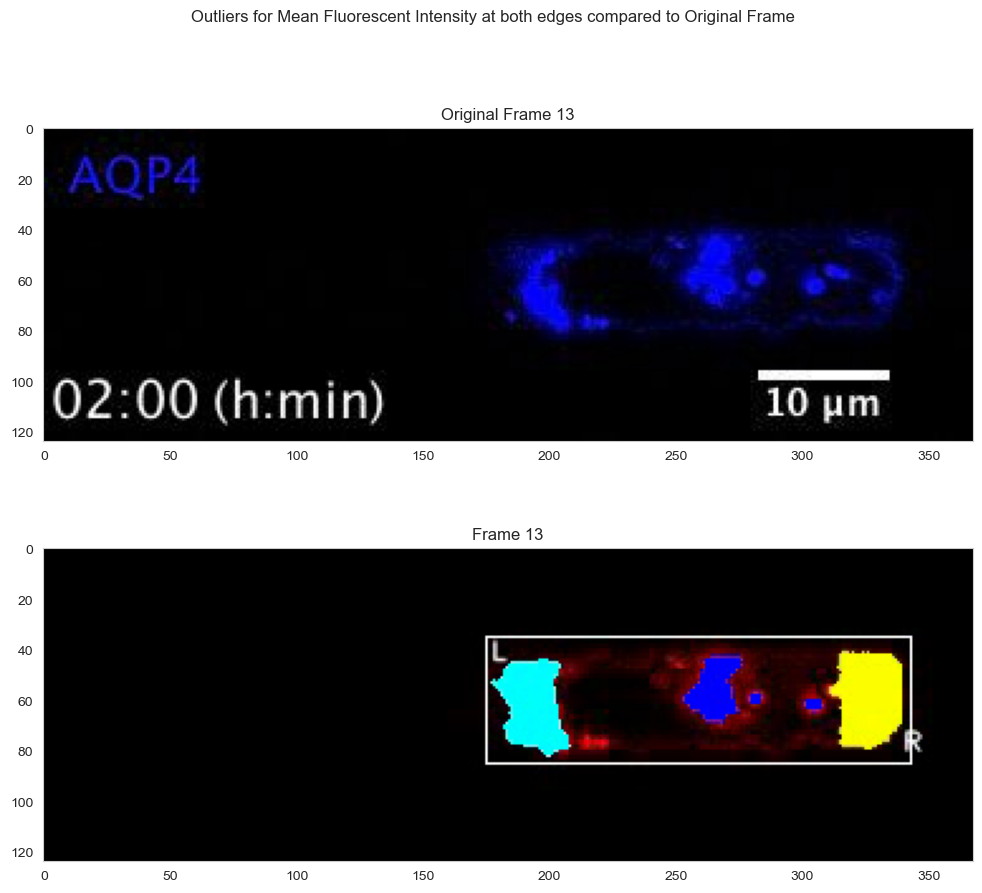

In [118]:
fig, (axes1, axes2) = plt.subplots(2, len(outliers), sharex=False, sharey=False, figsize=(12, 10))

video_name = "movie2_segments.avi"
cap = cv2.VideoCapture(video_name)

if len(outliers) > 1:
    for i in range(0, len(outliers)):
        frame = cv2.imread(f"movies/movie2/{outliers[i]}.jpg")
        axes1[i].grid(False)
        axes1[i].imshow(frame)
        axes1[i].set_title(f'Original Frame {outliers[i]}')
elif len(outliers) == 1:
    frame = cv2.imread(f"movies/movie2/{outliers[0]}.jpg")
    axes1.grid(False)
    axes1.imshow(frame)
    axes1.set_title(f'Original Frame {outliers[0]}')
    
if len(outliers) > 1:
    for i in range(0, len(outliers)):
        cap.set(1,outliers[i]-1)
        ret, frame = cap.read()
        axes2[i].grid(False)
        axes2[i].imshow(frame)
        axes2[i].set_title(f'Frame {outliers[i]}')
        
elif len(outliers) == 1:
    cap.set(1,outliers[0]-1)
    ret, frame = cap.read()
    axes2.grid(False)
    axes2.imshow(frame)
    axes2.set_title(f'Frame {outliers[0]}')
        
cap.release()
plt.suptitle("Outliers for Mean Fluorescent Intensity at both edges compared to Original Frame")
plt.savefig("movie2_outlier_on_frame13.png")
plt.show()

In [120]:
data_df[data_df["Frame"].isin(outliers)]

,Frame,Edge,Intensity Count,Mean Intensity
24,13,R,1912,34.714958
25,13,L,1730,67.497110


##### Right Edge outlier on Frame 13 fall above the upper range
- On Frame 13, high intensity fluorescence moved too close to the edge affecting the mean intensity.
- Adjusting the watershed markers affects the segments in other frames

## Analysis of Variance between Left Edge and Right Edge Fluorescence
- Test to see if the observed difference in fluorescence are statistically significant
- Effect of outliers on test

##### With Outliers

In [125]:
import scipy.stats as stats
stats.f_oneway(left_edge_data["Intensity Count"], right_edge_data["Intensity Count"])

F_onewayResult(statistic=5.00789046368044, pvalue=0.0347771920279548)

- There is no statistical significance between the number of detected fluorescence at 5% level of significance
- F-statistic = 5.01
- P-value = 0.035

In [128]:
stats.f_oneway(left_edge_data["Mean Intensity"], right_edge_data["Mean Intensity"])

F_onewayResult(statistic=480.39910781246925, pvalue=2.2197815463137558e-17)

- ANOVA test finds enough evidence for statistical difference between the means of Mean Fluorescent Intensity at Trailing and Leading edges
- F-statistic = 480.399
- P-value = 2.20e-17

##### Without outliers

In [132]:
right_edge_no_frame78 = right_edge_data[(right_edge_data['Frame']<13) | (right_edge_data['Frame']>13)]
left_edge_no_frame78 = left_edge_data[(left_edge_data['Frame']<13) | (left_edge_data['Frame']>13)]

In [134]:
stats.f_oneway(right_edge_no_frame78["Mean Intensity"], left_edge_no_frame78["Mean Intensity"])

F_onewayResult(statistic=490.1567204595029, pvalue=1.576660865144163e-16)

- ANOVA test finds enough evidence for statistical difference between the means of Mean Fluorescent Intensity at Trailing and Leading edges
- F-statistic = 490.157
- P-value = 1.577e-16